In [1]:
import torch
print(torch.__version__)

2.0.1


In [2]:
# Load Data
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet

data = MoleculeNet(root=".", name="ESOL")
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 32
loader = DataLoader(data[:int(data_size * 0.7)], batch_size=NUM_GRAPHS_PER_BATCH, shuffle = False)
test_loader = DataLoader(data[int(data_size * 0.7):int(data_size * 0.9)], batch_size=NUM_GRAPHS_PER_BATCH, shuffle = False)


C:\Users\illew\anaconda3\envs\rdkit_tf-gpu\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [3]:
# Define Graph Attention Network
from torch.nn import Linear, Dropout
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

torch.set_default_tensor_type(torch.cuda.FloatTensor)

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        torch.manual_seed(1234)

        self.num_features = 9
        self.emb_features = self.num_features*2

        # Attention
        self.Ws = []
        self.As = []
        self.k = 4 
        for i in range(self.k):
            self.Ws.append(torch.rand(self.emb_features,self.num_features)/(self.emb_features)**0.5)
            self.As.append(torch.rand(1,self.emb_features*2)/(self.emb_features)**0.5)

        # Linear
        self.W2 = torch.rand(2*self.emb_features,1)/(2*self.emb_features)**0.5
        self.b2 = torch.rand(1)
        self.dropout = Dropout(p=0.2)
    
        # Collate Parameters
        self.parameters = [self.W2, self.b2]
        for W in self.Ws:
            self.parameters.append(W)
        for A in self.As:
            self.parameters.append(A)   
        for p in self.parameters:
            p.requires_grad = True

    def attentionBlock(self, input_nodes, input_edges, Ws, As, index):
        embedded_vectors = F.tanh(Ws[index] @ input_nodes.t().float())
        e_ij = torch.zeros((input_nodes.shape[0],input_nodes.shape[0]))
        for i,j in input_edges.t():
            relation_vector = torch.cat((embedded_vectors.t()[i],embedded_vectors.t()[j]))
            e_ij[i][j] = F.leaky_relu(As[index] @ relation_vector, negative_slope=0.2)
        a_ij = F.softmax(e_ij, dim=1)
        return F.tanh(a_ij @ embedded_vectors.t())
        
    def forward(self, input_nodes, input_edges, batch_index):
        # Attention
        sum_heads = torch.zeros((input_nodes.shape[0],self.emb_features))
        for head in range(self.k):
            sum_heads+=self.attentionBlock(input_nodes,input_edges,self.Ws,self.As,head)
        avg_heads = sum_heads/self.k

        # Pooling
        hidden = torch.cat([gmp(avg_heads, batch_index), gap(avg_heads, batch_index)], dim = 1)
        
        # Dropout
        hidden = self.dropout(hidden)
        
        # Output Layer
        property_prediction = hidden @ self.W2 + self.b2
        
        return property_prediction

gratt_model = GAT()
print(gratt_model)
print("Number of Parameters: ", sum(p.numel() for p in gratt_model.parameters))
        
#Set GPU usage 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
gratt_model = gratt_model.to(device)

GAT(
  (dropout): Dropout(p=0.2, inplace=False)
)
Number of Parameters:  829


In [ ]:
# Training Loop
optimizer = torch.optim.Adam(gratt_model.parameters, lr=0.01)
losses = []

for epoch in range(1000):
    for batch in loader:
        # Forward pass
        batch = batch.to(device)
        property_prediction = gratt_model(batch.x.float(), batch.edge_index, batch.batch)
        loss = F.mse_loss(property_prediction,batch.y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Update
        optimizer.step()
    print(epoch, 'loss:{:0.5f} pred:{:0.5f},{:0.5f} real:{:0.5f},{:0.5f}'.format(loss.item(), property_prediction[0].item(),property_prediction[-1].item(),batch.y[0].item(),batch.y[-1].item()) )
    losses.append(loss)
    
    if loss == min(losses):
        torch.save(gratt_model,'21092023_gat.pt')


0 loss:6.54487 pred:-2.92032,-2.92024 real:-6.35000,-8.40000
1 loss:6.53022 pred:-3.35838,-3.50423 real:-6.35000,-8.40000
2 loss:6.17658 pred:-2.70019,-3.18647 real:-6.35000,-8.40000
3 loss:6.26292 pred:-2.95890,-2.64935 real:-6.35000,-8.40000
4 loss:5.86379 pred:-3.32647,-2.88671 real:-6.35000,-8.40000
5 loss:7.17330 pred:-2.36631,-2.92497 real:-6.35000,-8.40000
6 loss:6.01610 pred:-3.00754,-3.47322 real:-6.35000,-8.40000
7 loss:6.35164 pred:-2.91393,-3.19236 real:-6.35000,-8.40000
8 loss:6.85998 pred:-3.49899,-2.24425 real:-6.35000,-8.40000
9 loss:6.30168 pred:-2.88933,-2.63149 real:-6.35000,-8.40000
10 loss:6.29906 pred:-2.96331,-2.83009 real:-6.35000,-8.40000
11 loss:6.03984 pred:-3.04284,-2.99323 real:-6.35000,-8.40000
12 loss:7.05730 pred:-2.90492,-3.02872 real:-6.35000,-8.40000
13 loss:6.69302 pred:-2.81405,-2.28020 real:-6.35000,-8.40000
14 loss:6.86124 pred:-3.09852,-2.34088 real:-6.35000,-8.40000
15 loss:5.82901 pred:-3.22867,-3.17046 real:-6.35000,-8.40000
16 loss:6.44486 pr

132 loss:3.59879 pred:-5.28777,-2.73192 real:-6.35000,-8.40000
133 loss:2.95823 pred:-5.12124,-3.16290 real:-6.35000,-8.40000
134 loss:3.73508 pred:-5.90920,-2.80791 real:-6.35000,-8.40000
135 loss:3.22255 pred:-4.83323,-2.65583 real:-6.35000,-8.40000
136 loss:3.21216 pred:-5.89115,-1.94106 real:-6.35000,-8.40000
137 loss:2.88895 pred:-5.84008,-2.92944 real:-6.35000,-8.40000
138 loss:3.13483 pred:-5.28543,-3.39196 real:-6.35000,-8.40000
139 loss:3.24999 pred:-4.02254,-2.49216 real:-6.35000,-8.40000
140 loss:3.17232 pred:-6.45484,-3.35587 real:-6.35000,-8.40000
141 loss:3.14874 pred:-5.21015,-2.80080 real:-6.35000,-8.40000
142 loss:3.11591 pred:-3.74450,-4.02556 real:-6.35000,-8.40000
143 loss:3.65678 pred:-5.26862,-2.18823 real:-6.35000,-8.40000
144 loss:3.53091 pred:-5.10725,-2.66772 real:-6.35000,-8.40000
145 loss:3.00681 pred:-5.88250,-2.16743 real:-6.35000,-8.40000
146 loss:2.92115 pred:-5.61668,-2.84221 real:-6.35000,-8.40000
147 loss:2.75189 pred:-4.72115,-3.71930 real:-6.35000,-

263 loss:2.68470 pred:-4.86651,-3.63421 real:-6.35000,-8.40000
264 loss:1.79483 pred:-6.28293,-4.79097 real:-6.35000,-8.40000
265 loss:1.72768 pred:-5.83844,-4.53006 real:-6.35000,-8.40000
266 loss:2.49062 pred:-4.76274,-3.57627 real:-6.35000,-8.40000
267 loss:2.95840 pred:-5.58437,-2.82427 real:-6.35000,-8.40000
268 loss:2.59594 pred:-4.96291,-3.55277 real:-6.35000,-8.40000
269 loss:2.35438 pred:-4.68662,-3.67290 real:-6.35000,-8.40000
270 loss:1.70372 pred:-5.73711,-4.47830 real:-6.35000,-8.40000
271 loss:1.27741 pred:-6.68966,-5.07991 real:-6.35000,-8.40000
272 loss:1.97138 pred:-6.18144,-4.99872 real:-6.35000,-8.40000
273 loss:2.01299 pred:-4.49024,-4.32793 real:-6.35000,-8.40000
274 loss:2.16115 pred:-5.19589,-3.98523 real:-6.35000,-8.40000
275 loss:2.36847 pred:-4.07219,-4.90889 real:-6.35000,-8.40000
276 loss:1.49171 pred:-5.94329,-4.14334 real:-6.35000,-8.40000
277 loss:2.14662 pred:-6.01615,-4.55416 real:-6.35000,-8.40000
278 loss:3.12326 pred:-4.87508,-2.05275 real:-6.35000,-

In [10]:
# Load Trained Model
gratt_model = torch.load('23092023_gat.pt')
gratt_model.to(device)

GAT(
  (dropout): Dropout(p=0.2, inplace=False)
)

In [11]:
# Inference
def inference(model, loader):
    reals = []
    predicteds = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            property_prediction = model(batch.x.float(), batch.edge_index, batch.batch)
            loss = F.mse_loss(property_prediction,batch.y)
            for i,j in zip(property_prediction, batch.y):
                predicteds.append(i.item())
                reals.append(j.item())
    return reals, predicteds
    
train_real, train_pred = inference(gratt_model, loader)
test_real, test_pred = inference(gratt_model, test_loader)    


TRAIN - MSE: 0.8690916476981154 R2: 0.7995624131025411
TEST - MSE: 1.1336054482305207 R2: 0.7639835946644069


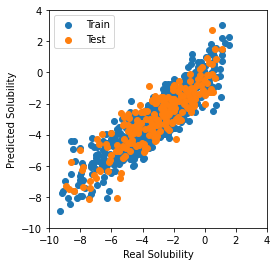

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Plotting
fig,ax = plt.subplots()
plt.scatter(train_real, train_pred)
plt.scatter(test_real, test_pred)

# Formatting
plt.xlabel("Real Solubility")
plt.ylabel("Predicted Solubility")
ax.legend(['Train', 'Test'])
ax.set_aspect('equal', adjustable='box')
ax.set_box_aspect(1)
ax.set_xlim(-10,4)
ax.set_ylim(-10,4)

print('TRAIN - MSE:',mean_squared_error(train_real, train_pred),'R2:',r2_score(train_real, train_pred))
print('TEST - MSE:',mean_squared_error(test_real, test_pred),'R2:',r2_score(test_real, test_pred))